# 1. Formulate the problem

Topic Description: Fine-tune a pre-trained encoder-decoder language model (e.g., T5 or BART) to
generate a compelling title for a scientific paper given its abstract. This is an abstractive text
summarization task.
The dataset is a CSV file containing metadata for 136,238 scientific papers from
arXiv. It includes the paper's summary (input) and title (target).

# 2. Identify inputs and outputs

## Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/datasets/arXiv_scientific dataset.csv"
import pandas as pd

df = pd.read_csv(DATA_PATH)

df = df[["summary", "title"]]

df = df.dropna().reset_index(drop=True)


df.head()


summary  \
0  Because of their occasional need to return to ...   
1  Market price systems constitute a well-underst...   
2  We describe an extensive study of search in GS...   
3  As real logic programmers normally use cut (!)...   
4  To support the goal of allowing users to recor...   

                                               title  
0                               Dynamic Backtracking  
1  A Market-Oriented Programming Environment and ...  
2            An Empirical Analysis of Search in GSAT  
3  The Difficulties of Learning Logic Programs wi...  
4  Software Agents: Completing Patterns and Const...

In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df["summary"] = df["summary"].apply(clean_text)
df["title"] = df["title"].apply(clean_text)


In [ ]:
df["input_text"] = "generate title: " + df["summary"]
df["target_text"] = df["title"]


# 3. Prepare data

## Inspect and vizualizing data

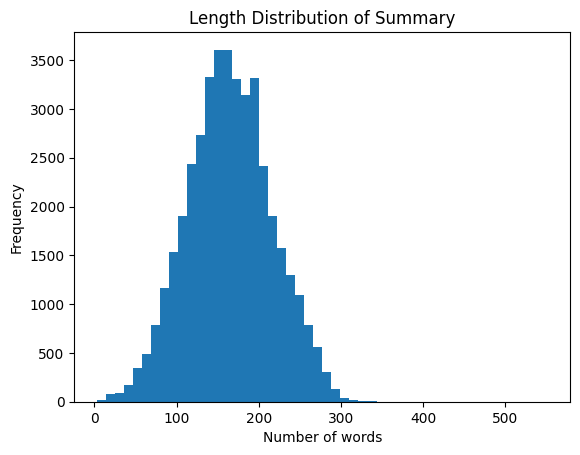

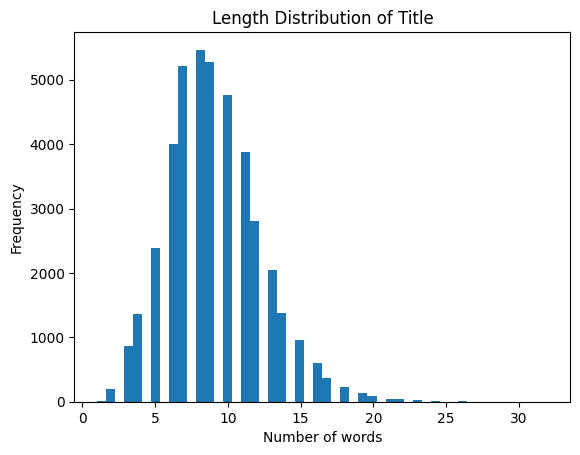

In [ ]:
import matplotlib.pyplot as plt

df["summary_len"] = df["summary"].astype(str).apply(lambda x: len(x.split()))
df["title_len"] = df["title"].astype(str).apply(lambda x: len(x.split()))

plt.figure()
plt.hist(df["summary_len"], bins=50)
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.title("Length Distribution of Summary")
plt.show()

plt.figure()
plt.hist(df["title_len"], bins=50)
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.title("Length Distribution of Title")
plt.show()



The length distribution shows that the summaries follow a normal distribution, with most texts falling between 100 and 250 words and peaking around 150 words. In contrast, the titles are right-skewed, typically ranging from 5 to 12 words, which reflects their concise nature. Overall, the data is consistent and well-distributed, making it suitable for training with a maximum length of 300 for summaries and 20 for titles.

## Split data into training and test set

In [ ]:
from datasets import Dataset

dataset = Dataset.from_pandas(
    df[["input_text", "target_text"]]
)
dataset = dataset.train_test_split(test_size=0.2, seed=42)
test_valid = dataset["test"].train_test_split(test_size=0.5, seed=42)

train_dataset = dataset["train"]
valid_dataset = test_valid["train"]
test_dataset  = test_valid["test"]


# 4-7. Optimazie -  Specify - Measure - Inference

PeftModelForSeq2SeqLM is a parameter-efficient fine-tuning framework designed for sequence-to-sequence language models such as BART. It enables efficient adaptation by training only a small subset of additional parameters (e.g., via LoRA) while keeping the original pretrained weights frozen. This approach significantly reduces computational cost and memory usage, while maintaining strong performance on text generation tasks.

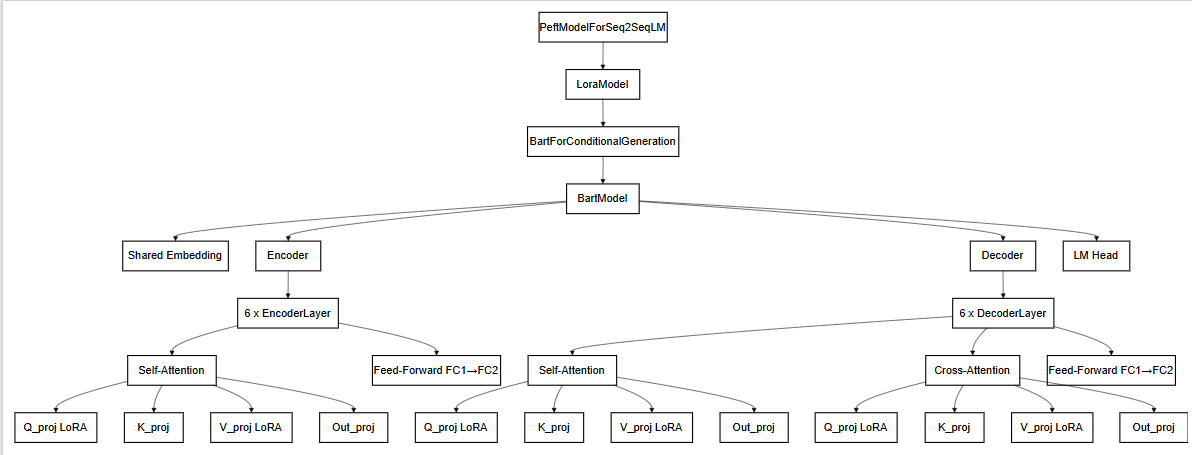

In [ ]:
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [ ]:
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 32
def tokenize_function(batch):
    model_inputs = tokenizer(
        batch["input_text"],
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["target_text"],
            max_length=MAX_TARGET_LENGTH,
            truncation=True,
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=train_dataset.column_names
)

tokenized_valid = valid_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=valid_dataset.column_names
)

tokenized_test = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=test_dataset.column_names
)


Map:   0%|          | 0/33749 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/4219 [00:00<?, ? examples/s]

Map:   0%|          | 0/4219 [00:00<?, ? examples/s]

In [ ]:
!pip install peft

In [ ]:
print(tokenized_train[0])


{'input_ids': [0, 20557, 877, 1270, 35, 42, 2225, 6822, 41, 14082, 9, 5, 20299, 1707, 17194, 7, 6136, 5, 3521, 12278, 936, 13, 11, 4092, 8, 66, 4092, 12668, 4, 42, 936, 16, 8069, 2811, 1533, 11255, 1907, 36, 32786, 6, 490, 526, 6, 490, 299, 6, 6013, 6, 5802, 8, 20659, 1070, 43, 61, 8382, 5, 1068, 55, 6336, 6, 25, 1337, 3521, 16311, 1382, 4, 5, 4554, 16, 7, 465, 41, 19329, 11255, 9804, 61, 13947, 49, 5824, 5461, 6, 8, 15925, 5, 769, 12, 26628, 1414, 9, 12668, 4, 5, 819, 9, 5, 1850, 1548, 16, 13031, 12818, 7, 5, 775, 5129, 30, 9186, 17194, 8, 14241, 139, 17194, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [0, 22417, 6119, 1707, 7, 6136, 5, 11255, 3521, 936, 19, 4

In [ ]:
from transformers import BartForConditionalGeneration

model = BartForConditionalGeneration.from_pretrained(
    "facebook/bart-base"
)
model = model.to("cuda")




model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
from transformers import TrainingArguments
import os

OUTPUT_DIR = "/content/drive/MyDrive/bart_title_generation"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="steps",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=3e-5,
    num_train_epochs=3,
    warmup_steps=500,
    logging_steps=200,
    eval_steps=1000,
    save_steps=1000,
    save_total_limit=2,
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="rougeL"
)


In [ ]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a9107fc0135c26e75e4788e0b1d0cd853e8d0dc5ab9badbb6e35e38de97549d6
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
!pip install evaluate sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.7 MB/s eta 0:00:00


In [ ]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.9 MB/s eta 0:00:00


In [ ]:


import evaluate
import numpy as np

rouge_metric = evaluate.load("rouge")
bleu_metric = evaluate.load("bleu")
meteor_metric = evaluate.load("meteor")
bertscore_metric = evaluate.load("bertscore")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(
        np.where(preds != -100, preds, tokenizer.pad_token_id),
        skip_special_tokens=True
    )
    decoded_labels = tokenizer.batch_decode(
        np.where(labels != -100, labels, tokenizer.pad_token_id),
        skip_special_tokens=True
    )

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]


    rouge = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    formatted_labels = [[label] for label in decoded_labels]
    bleu = bleu_metric.compute(predictions=decoded_preds, references=formatted_labels)

    meteor = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)

    bertscore = bertscore_metric.compute(predictions=decoded_preds, references=decoded_labels, lang="en")

    return {
        "rouge1": rouge["rouge1"] * 100,
        "rouge2": rouge["rouge2"] * 100,
        "rougeL": rouge["rougeL"] * 100,
        "bleu": bleu["bleu"] * 100,
        "meteor": meteor["meteor"] * 100,
        "bertscore_f1": np.mean(bertscore["f1"]) * 100 # Lấy trung bình F1 score của cả tập
    }



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import torch
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from peft import LoraConfig, get_peft_model, TaskType
import numpy as np
from rouge_score import rouge_scorer

model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")


peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1
)


model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=-100
)

training_args = Seq2SeqTrainingArguments(
    do_train=True,
    do_eval=True,
    eval_strategy="steps",


    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,

    learning_rate=1e-3,
    num_train_epochs=1,
    logging_steps=100,
    save_steps=1000,
    save_total_limit=2,

    fp16=True,
    predict_with_generate=True,
    report_to="none"
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)



trainable params: 884,736 || all params: 140,305,152 || trainable%: 0.6306


/tmp/ipython-input-479057262.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
print(model)

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): BartForConditionalGeneration(
      (model): BartModel(
        (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
        (encoder): BartEncoder(
          (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
          (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
          (layers): ModuleList(
            (0-5): 6 x BartEncoderLayer(
              (self_attn): BartAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
   

In [ ]:
torch.save(model, "model.pt")

In [ ]:
!pip install torchviz

import torch
from torchviz import make_dot

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

input_ids = torch.randint(0, 50265, (1,32)).to(device)
decoder_input_ids = torch.randint(0, 50265, (1,32)).to(device)


outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
loss = outputs.logits.sum()


dot = make_dot(loss, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('bart_lora_model')
from IPython.display import Image
Image('bart_lora_model.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.959446 to fit


In [ ]:
trainer.train()

TrainOutput(global_step=2110, training_loss=2.4912104159169854, metrics={'train_runtime': 6237.929, 'train_samples_per_second': 5.41, 'train_steps_per_second': 0.338, 'total_flos': 7017139791230976.0, 'train_loss': 2.4912104159169854, 'epoch': 1.0})

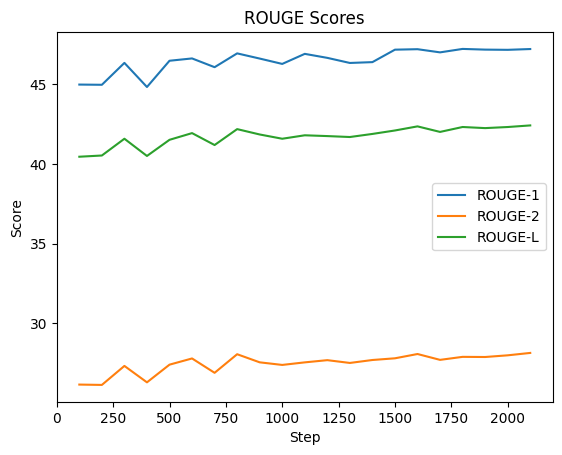

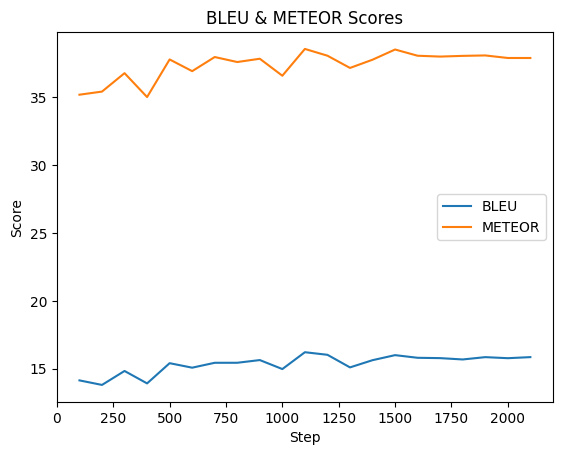

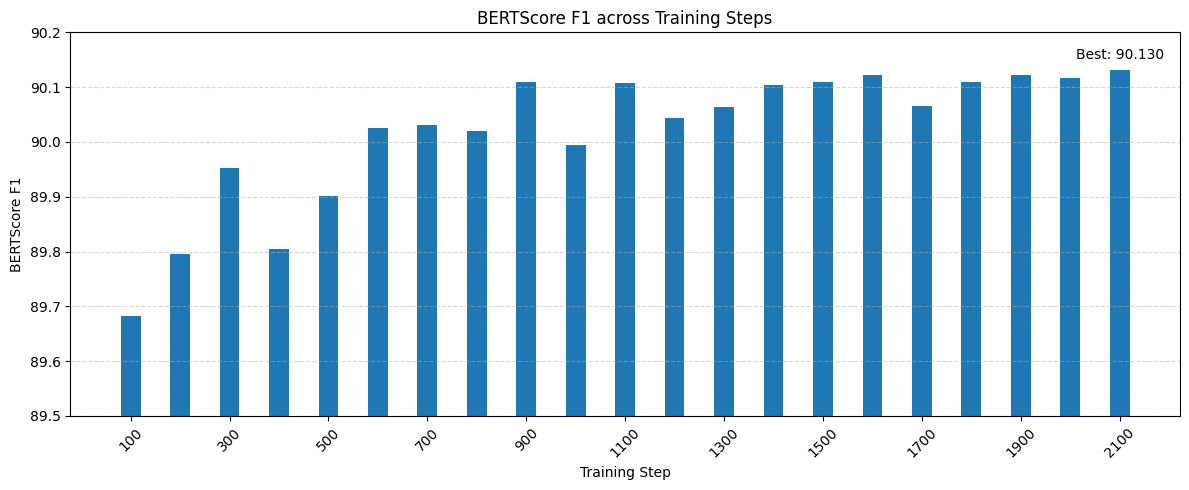

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data
steps = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100]

rouge1 = [44.9842,44.9707,46.3442,44.8323,46.4791,46.6245,46.0757,46.9419,46.6167,46.2804,46.9115,46.6601,46.3405,46.3927,47.1748,47.2041,47.0052,47.2215,47.1779,47.1647,47.2141]
rouge2 = [26.1571,26.1354,27.3276,26.2973,27.4073,27.7965,26.8954,28.0620,27.5531,27.3903,27.5508,27.6893,27.5144,27.6994,27.8061,28.0749,27.7079,27.8967,27.8873,27.9930,28.1432]
rougel = [40.4562,40.5325,41.5848,40.5040,41.5175,41.9381,41.1897,42.1889,41.8525,41.5849,41.8013,41.7515,41.6930,41.8866,42.1032,42.3609,42.0131,42.3214,42.2522,42.3204,42.4208]

bleu = [14.1370,13.8032,14.8308,13.9152,15.4044,15.0732,15.4336,15.4348,15.6335,14.9716,16.2121,16.0218,15.0942,15.6256,15.9969,15.8015,15.7767,15.6784,15.8495,15.7722,15.8508]
meteor = [35.1797,35.4093,36.7664,35.0066,37.7763,36.9146,37.9547,37.5867,37.8288,36.5776,38.5519,38.0522,37.1513,37.7574,38.5084,38.0497,37.9880,38.0399,38.0721,37.8839,37.8830]
bertscore = [89.6829,89.7946,89.9530,89.8053,89.9011,90.0246,90.0315,90.0208,90.1086,89.9945,90.1068,90.0432,90.0646,90.1042,90.1088,90.1225,90.0648,90.1095,90.1228,90.1164,90.1305]


plt.figure()
plt.plot(steps, rouge1, label="ROUGE-1")
plt.plot(steps, rouge2, label="ROUGE-2")
plt.plot(steps, rougel, label="ROUGE-L")
plt.xlabel("Step")
plt.ylabel("Score")
plt.title("ROUGE Scores")
plt.legend()
plt.show()


plt.figure()
plt.plot(steps, bleu, label="BLEU")
plt.plot(steps, meteor, label="METEOR")
plt.xlabel("Step")
plt.ylabel("Score")
plt.title("BLEU & METEOR Scores")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))

bars = plt.bar(steps, bertscore, width=40)

best_idx = np.argmax(bertscore)
bars[best_idx].set_alpha(1.0)

plt.xlabel("Training Step")
plt.ylabel("BERTScore F1")
plt.title("BERTScore F1 across Training Steps")
plt.ylim(89.5, 90.2)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.xticks(steps[::2], rotation=45)

plt.text(
    steps[best_idx],
    bertscore[best_idx] + 0.02,
    f"Best: {bertscore[best_idx]:.3f}",
    ha="center",
    fontsize=10
)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from rouge_score import rouge_scorer


In [ ]:
from transformers import BartTokenizerFast, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

trainer.tokenizer = tokenizer

print("Đang đánh giá lại trên tập Test với Fast Tokenizer...")
test_results = trainer.evaluate(tokenized_test)

print("-" * 30)
print(f"BLEU Score: {test_results['eval_bleu']:.2f}%")
print(f"ROUGE-1:    {test_results['eval_rouge1']:.2f}%")
print(f"ROUGE-2:    {test_results['eval_rouge2']:.2f}%")
print(f"ROUGE-L:    {test_results['eval_rougeL']:.2f}%")
print(f"METEOR:       {test_results.get('eval_meteor', 0):.2f}%")
print(f"BERTScore F1: {test_results.get('eval_bertscore_f1', 0):.2f}%")
print("-" * 30)

Trainer.tokenizer is now deprecated. You should use `Trainer.processing_class = processing_class` instead.


Đang đánh giá lại trên tập Test với Fast Tokenizer...


------------------------------
BLEU Score: 15.85%
ROUGE-1:    47.40%
ROUGE-2:    28.03%
ROUGE-L:    42.46%
METEOR:       37.91%
BERTScore F1: 90.16%
------------------------------


In [ ]:
import random
import torch
import textwrap

samples = test_dataset.select(range(5))

print("\n=== Example (FULL TEXT) ===")
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"

for i, sample in enumerate(samples):
    input_text = sample["input_text"]
    reference = sample["target_text"]

    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)

    outputs = model.generate(
        **inputs,
        max_length=64,
        num_beams=4,
        early_stopping=True
    )

    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

    print(f"Example{i+1}:")
    print("-" * 20)
    print("INPUT (ABSTRACT):")
    print(textwrap.fill(input_text, width=100))
    print("-" * 20)
    print(f"The true title (Ref): {reference}")
    print(f"The predicted title (Pred): {prediction}")
    print("=" * 80)
    print("\n")


=== Example (FULL TEXT) ===
Example1:
--------------------
INPUT (ABSTRACT):
generate title: recently, bert realized significant progress for sentence matching via word-level
cross sentence attention. however, the performance significantly drops when using siamese bert-
networks to derive two sentence embeddings, which fall short in capturing the global semantic since
the word-level attention between two sentences is absent. in this paper, we propose a dual-view
distilled bert~(dvbert) for sentence matching with sentence embeddings. our method deals with a
sentence pair from two distinct views, i.e., siamese view and interaction view. siamese view is the
backbone where we generate sentence embeddings. interaction view integrates the cross sentence
interaction as multiple teachers to boost the representation ability of sentence embeddings.
experiments on six sts tasks show that our method outperforms the state-of-the-art sentence
embedding methods significantly.
--------------------
Th

# 8. Conclusion

The implementation of LoRA (Low-Rank Adaptation) for the BART model has proven to be a highly effective strategy. This approach perfectly aligns with the project's core objective of "Efficient Training" by significantly reducing the number of trainable parameters while maintaining high performance. The experimental results, evidenced by impressive ROUGE and BERTScore metrics, demonstrate that fine-tuning with LoRA achieves a balance between computational efficiency and the linguistic quality of the generated summaries.

Future Work Moving forward, several promising directions can be explored to further enhance the system. First, the methodology could be scaled to larger architectures, such as BART-large or T5-large, to investigate potential improvements in semantic depth. Additionally, integrating Quantization techniques, specifically QLoRA (4-bit or 8-bit), presents a significant opportunity to further minimize memory footprints and hardware requirements, making the model even more accessible for deployment on resource-constrained environments.